In [1]:
from datasets import BitcoinOTC, BitcoinAlpha, AS733, UCIMessage, SBM, StackOverflow, RedditTitle, RedditBody
from dataloader import BitcoinLoaderFactory
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm
import torch
import os
import numpy as np
import pandas as pd
from torch_geometric.datasets import JODIEDataset

datasets = []

datasets.append(BitcoinOTC('./data/bitcoin', transform=None))
datasets.append(BitcoinAlpha('./data/bitcoin', transform=None))
datasets.append(UCIMessage('./data/uci-msg', transform=None))
datasets.append(RedditTitle('./data/reddit', transform=None))
datasets.append(RedditBody('./data/reddit', transform=None))
datasets.append(AS733('./data/as-733', transform=None))
datasets.append(StackOverflow('./data/stackoverflow', transform=None))
datasets.append(SBM('./data/sbm', transform=None))


datanames = [
    'bitcoinalpha', 'bitcoinotc', 'uci', 'redt', 'redb',
    'as733', 'stackoverflow', 'sbm'
]

/mnt/zj-gpfs/home/qiqingguo/miniconda3/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /mnt/zj-gpfs/home/qiqingguo/miniconda3/lib/python3.12/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
from  torch_geometric.utils import degree

for ds in datasets:
    nnode2 = ds.num_nodes
    nedge = np.sum([d.edge_index.size(1) for d in ds])
    nnz = nedge / nnode2
    #nnz = np.mean([degree(d.edge_index[0], ds.num_nodes).mean() for d in ds])
    print(f'{nnz:.2f}')

6.05
6.39
31.52
10.58
8.01
1550.74
24.40
4870.86


In [3]:
for ds in datasets:
    nnode2 = ds.num_nodes
    nnz = np.mean([d.edge_index.size(1) / nnode2 for d in ds])
    print(f'{nnz:.2f}')


0.04
0.05
0.36
0.06
0.05
2.12
0.12
97.42


<Axes: >

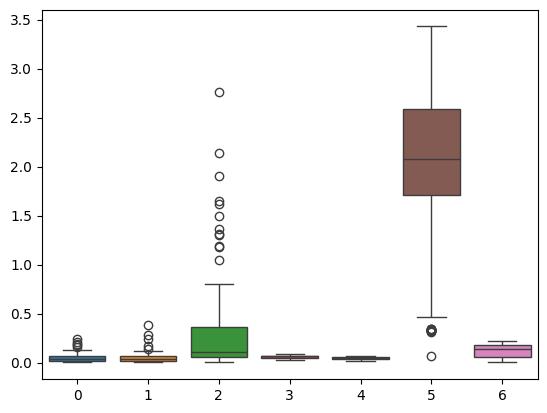

In [4]:
ratio = []
for ds in datasets[:-1]: # sbm ~ 100
    r = []
    for d in ds:
        r.append( len(d.edge_attr) / d.num_nodes )
    ratio.append(r)

sbn.boxplot(ratio)

In [5]:
import os

class ParseExperimentLog():
    def __init__(self):
        pass

    def parse_line(self, line, pos):
        return line.strip().split(' ')[pos]

    def read_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            #print(file_path)
            if len(lines) > 48:
                if len(lines) % 48 == 0:
                    lines = lines[-48:]
                else:
                    lines = lines[-50:]
            runs = int(self.parse_line(lines[10], -1))
            ds = self.parse_line(lines[1], -1)
            model = self.parse_line(lines[2], -1)
            mini = self.parse_line(lines[32], -1)
            gpu_mem = float(self.parse_line(lines[34], -2))
            epoch_time = float(self.parse_line(lines[36], -2))
            train_time = float(self.parse_line(lines[37], -2))
            mr = 42 + runs
            mean = [float(x.strip()) for x in lines[mr].split('|')[3:9]]
            std  = [float(x.strip()) for x in lines[mr+1].split('|')[3:9]]
            if mini == 'True':
                type = 'mini'
            elif len(file_path.split('.')) > 2:
                type = 'exp'
            else:
                type = 'main'

            exp_name = ''
            exp_param = 0
            if type == 'exp':
                exp_name = file_path.split('.', 1)[1][:-4]
                if exp_name.startswith('window-') or  exp_name.startswith('dropout-') \
                or exp_name.startswith('heads-') or  exp_name.startswith('hidden-') \
                or exp_name.startswith('learnrate-') or  exp_name.startswith('n_neg_train-'):
                    arr = exp_name.split('-')
                    exp_name = arr[0]
                    exp_param = arr[1]
            if model == 'roland' and file_path.endswith('_meta.log'):
                model = model + '_meta'
            return {
                'dataset': ds,
                'model': model,
                'gpu_mem': gpu_mem,
                'epoch_time': epoch_time,
                'train_time': train_time,
                'mrr_mean': mean[0],
                'hit@1_mean': mean[1],
                'hit@3_mean': mean[2],
                'hit@10_mean': mean[3],
                'auc_mean': mean[4],
                'ap_mean': mean[5],
                'mrr_std': std[0],
                'hit@1_std': std[1],
                'hit@3_std': std[2],
                'hit@10_std': std[3],
                'auc_std': std[4],
                'ap_std': std[5],
                'type': type,
                'exp_name': exp_name,
                'exp_param': float(exp_param),
            }
    
    def read_all(self, log_path='log'):
        records = []
        for file in os.listdir(log_path): 
            if file.endswith(".log"): 
                file_path = f"log/{file}"
                records.append(self.read_file(file_path))
        return pd.DataFrame(records)

parser = ParseExperimentLog()
df = parser.read_all()

In [6]:
df

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
0,sbm,hgcn,5543.49,10.54,375.76,0.2886,0.2444,0.2799,0.3490,0.6931,0.6368,0.0042,0.0057,0.0031,0.0015,0.0041,0.0023,exp,n_neg_train,10.0
1,sbm,gcn,2462.81,3.42,103.77,0.2691,0.2237,0.2619,0.3346,0.6415,0.6172,0.0046,0.0065,0.0027,0.0044,0.0388,0.0148,main,,0.0
2,stackoverflow,hgat,8211.86,369.89,9370.54,0.4784,0.3543,0.5415,0.7363,0.8356,0.8737,0.0005,0.0016,0.0022,0.0086,0.0004,0.0002,mini,,0.0
3,redb,hgat,558.68,3.94,196.97,0.4123,0.2852,0.4693,0.6673,0.8483,0.8720,0.0045,0.0061,0.0031,0.0018,0.0030,0.0021,exp,n_neg_train,6.0
4,redt,hgat,1000.95,4.15,207.56,0.4699,0.3610,0.5293,0.6855,0.8257,0.8299,0.0005,0.0009,0.0003,0.0001,0.0000,0.0001,exp,window,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,redt,evolve-h,1249.29,36.88,1008.10,0.3068,0.2675,0.3029,0.3495,0.6314,0.6422,0.0001,0.0000,0.0001,0.0004,0.0078,0.0024,exp,n_neg_train,6.0
807,sbm,evolve-o,3882.73,38.33,817.67,0.2138,0.1614,0.2132,0.2916,0.5733,0.5770,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,1.0
808,bitcoinalpha,hgcn,143.79,2.98,89.49,0.4231,0.2513,0.5300,0.7745,0.8627,0.8543,0.0603,0.0254,0.0878,0.1466,0.0712,0.0697,exp,n_neg_train,20.0
809,stackoverflow,hgcn,13977.29,54.23,2512.47,0.4615,0.3309,0.5228,0.7509,0.8412,0.8753,0.0024,0.0007,0.0060,0.0036,0.0010,0.0011,exp,n_neg_train,9.0


In [7]:
df.model.unique()

array(['hgcn', 'gcn', 'hgat', 'evolve-o', 'ghp', 'lstmgcn', 'evolve-h',
       'dysat', 'graphmixer', 'roland_meta', 'wingnn', 'vgrnn', 'm2dne',
       'htgn', 'gat', 'roland'], dtype=object)

In [8]:
df.query('type == "main" and model == "roland"')

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
219,redb,roland,596.27,0.04,282.26,0.3861,0.2579,0.4243,0.6628,0.8789,0.8855,0.0134,0.0143,0.0149,0.0096,0.0035,0.0041,main,,0.0
281,uci,roland,433.89,0.03,118.82,0.1859,0.0743,0.2066,0.4277,0.6931,0.7274,0.0226,0.0164,0.0321,0.0364,0.0132,0.0141,main,,0.0
370,bitcoinotc,roland,331.16,0.03,187.43,0.2920,0.1455,0.3450,0.6148,0.8009,0.8416,0.0071,0.0093,0.0119,0.0082,0.0119,0.0077,main,,0.0
447,bitcoinalpha,roland,326.01,0.03,169.64,0.2834,0.1473,0.3265,0.5702,0.8057,0.8331,0.0101,0.0176,0.0169,0.0137,0.0072,0.0069,main,,0.0
469,sbm,roland,2580.18,0.09,99.46,0.0202,0.0002,0.0003,0.0008,0.5018,0.5009,0.0009,0.0002,0.0005,0.0011,0.0025,0.0013,main,,0.0
478,stackoverflow,roland,23205.11,1.00,3152.95,0.3841,0.2545,0.4245,0.6697,0.8373,0.8577,0.0124,0.0116,0.0173,0.0132,0.0057,0.0057,main,,0.0
524,as733,roland,2227.02,0.08,354.38,0.3527,0.2052,0.3758,0.6328,0.8818,0.8639,0.0066,0.0202,0.0040,0.0176,0.0121,0.0029,main,,0.0
544,redt,roland,1059.62,0.05,398.73,0.4600,0.3312,0.5117,0.7273,0.9052,0.9100,0.0218,0.0177,0.0289,0.0301,0.0106,0.0106,main,,0.0


In [11]:
#df.query('type == "main" and model == "hgat"')
df.to_csv('res-all.csv', index=False)

# Main Table

/mnt/zj-gpfs/home/qiqingguo/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_3932157/255688341.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)


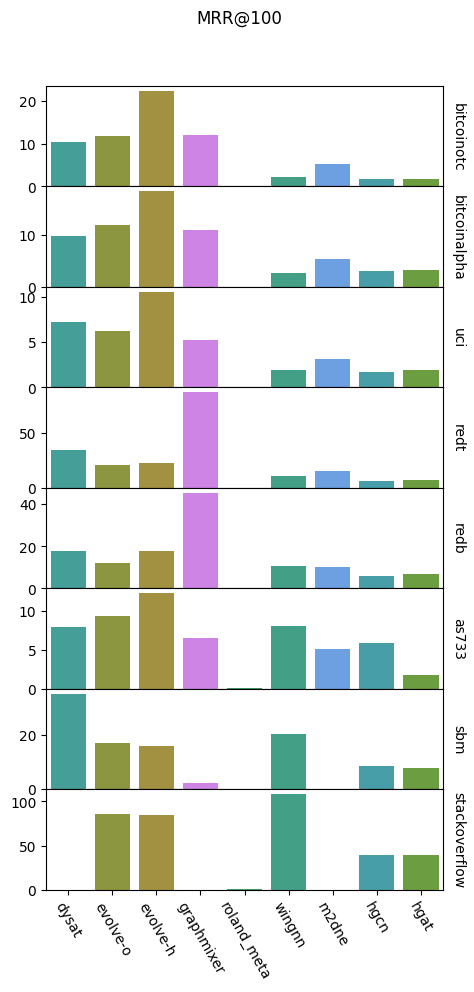

In [10]:
hue_order = [
    'dysat', 'evolve-o', 'evolve-h', 'graphmixer', 'roland_meta', 'wingnn', 'm2dne', 'hgcn', 'hgat',
]
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
g1 = sbn.FacetGrid(df.query('type == "main"'), row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="epoch_time", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < len(row_order):
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("MRR@1000")
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g1.fig.suptitle('MRR@100')
g1.set_xlabels("")

In [14]:
df.query('type == "main" and dataset=="as733"')

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
104,as733,lstmgcn,19713.32,10.24,511.76,0.6073,0.5471,0.6091,0.7614,0.9301,0.9135,0.0056,0.0056,0.0077,0.0041,0.0017,0.0022,main,,0.0
113,as733,hgcn,2210.84,5.92,181.60,0.4434,0.3323,0.4816,0.6547,0.8999,0.8729,0.0041,0.0194,0.0161,0.0686,0.0250,0.0259,main,,0.0
116,as733,vgrnn,2975.80,5.70,189.94,0.4194,0.3259,0.4511,0.5719,0.8658,0.8464,0.0204,0.0118,0.0343,0.0364,0.0130,0.0065,main,,0.0
140,as733,ghp,1228.78,4.25,148.68,0.2215,0.1909,0.2083,0.2591,0.4976,0.4991,0.0488,0.0578,0.0501,0.0372,0.0006,0.0004,main,,0.0
189,as733,dysat,2493.65,7.92,332.72,0.2510,0.2153,0.2491,0.2629,0.5404,0.5353,0.0171,0.0079,0.0229,0.0286,0.0139,0.0086,main,,0.0
198,as733,graphmixer,2207.53,6.56,279.73,0.2886,0.1286,0.3113,0.5902,0.8926,0.8514,0.0000,0.0002,0.0002,0.0011,0.0001,0.0001,main,,0.0
226,as733,hgat,2211.58,1.74,86.95,0.4595,0.3515,0.4820,0.6843,0.9257,0.9060,0.0079,0.0098,0.0106,0.0134,0.0075,0.0086,main,,0.0
257,as733,wingnn,319.96,8.02,192.54,0.0429,0.0133,0.0226,0.0502,0.5076,0.5058,0.0210,0.0112,0.0207,0.0547,0.0054,0.0042,main,,0.0
428,as733,roland_meta,2227.37,0.11,433.15,0.2121,0.0586,0.2058,0.5655,0.8486,0.8174,0.0573,0.0470,0.0881,0.0350,0.0074,0.0110,main,,0.0
462,as733,gcn,2205.56,2.87,142.46,0.4929,0.4059,0.5235,0.6431,0.8771,0.8699,0.0006,0.0080,0.0039,0.0196,0.0282,0.0180,main,,0.0


In [236]:
hue_order = [
    'dysat', 'evolve-o', 'roland_meta', 'wingnn', 'vgrnn', 'htgn', 'graphmixer',  'm2dne', 'ghp', 'hgcn', 'hgat',
]
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
# hue_order = [
#     'graphmixer',
# ]
b_map = {
    'dysat': '\\texttt{DySAT}',
    'evolve-o': '\\texttt{EvolveGCN}',
    'graphmixer': '\\texttt{GraphMixer}',
    'vgrnn': '\\texttt{VGRNN}',
    'htgn': '\\texttt{HTGN}',
    'm2dne': '\\texttt{M2DNE}',
    'ghp': '\\texttt{GHP}',
    'wingnn': '\\texttt{WinGNN}',
    'roland_meta': '\\texttt{Roland}',
    'hgcn': '\\texttt{SFDyG-GCN}',
    'hgat': '\\texttt{SFDyG-GAT}',
}
sf=df.query('type == "main"')
mrr_table = []
for model in hue_order:
    mrr_list = []
    for ds in row_order:
        order = sf.query(f'dataset == "{ds}" and model in {hue_order}').sort_values(by='mrr_mean', ascending=False).reset_index()
        rank = {}
        for i, row in order.iterrows():
            rank[row['model']] = i
         
        record = sf.query(f'model == "{model}" and dataset == "{ds}"')
        # print(record.dataset)
        if len(record) == 0:
            mrr_list.append('OOM.')
        else:
            val = f"{record['mrr_mean'].values[0]*100:.2f} $\pm$ {record['mrr_std'].values[0]*100:.2f}"
            if rank[model] == 0:
                mrr_list.append("\\textbf{" + val + "}")
            elif rank[model] == 1:
                mrr_list.append("\\underline{" + val + "}")
            else:
                mrr_list.append(val)
    mrr_table.append(b_map[model] + '   &' + ' & '.join(mrr_list) + '    \\\\')
    print(mrr_table[-1])


<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2408233/455111722.py:36: SyntaxWarning: invalid escape sequence '\p'
  val = f"{record['mrr_mean'].values[0]*100:.2f} $\pm$ {record['mrr_std'].values[0]*100:.2f}"


\texttt{DySAT}   &21.39 $\pm$ 2.79 & 19.16 $\pm$ 2.21 & 23.31 $\pm$ 9.42 & 17.46 $\pm$ 4.18 & 13.87 $\pm$ 3.90 & 25.10 $\pm$ 1.71 & 6.88 $\pm$ 0.53 & OOM.    \\
\texttt{EvolveGCN}   &7.84 $\pm$ 0.09 & 6.65 $\pm$ 0.55 & 7.33 $\pm$ 0.15 & 30.67 $\pm$ 0.00 & 18.55 $\pm$ 0.02 & 42.06 $\pm$ 0.00 & 21.38 $\pm$ 0.00 & 31.21 $\pm$ 0.48    \\
\texttt{Roland}   &30.94 $\pm$ 0.70 & 32.97 $\pm$ 1.78 & 17.04 $\pm$ 2.30 & 46.33 $\pm$ 0.27 & \underline{38.57 $\pm$ 0.42} & 21.21 $\pm$ 5.73 & 1.96 $\pm$ 0.00 & 38.57 $\pm$ 1.44    \\
\texttt{WinGNN}   &3.86 $\pm$ 1.26 & 3.90 $\pm$ 0.84 & 2.37 $\pm$ 0.13 & 4.19 $\pm$ 1.25 & 2.69 $\pm$ 0.38 & 4.29 $\pm$ 2.10 & 3.35 $\pm$ 0.50 & 7.51 $\pm$ 0.67    \\
\texttt{VGRNN}   &6.62 $\pm$ 0.10 & 6.49 $\pm$ 0.29 & 6.96 $\pm$ 0.08 & OOM. & 17.19 $\pm$ 0.14 & 41.94 $\pm$ 2.04 & 19.79 $\pm$ 0.23 & OOM.    \\
\texttt{HTGN}   &6.36 $\pm$ 0.06 & 7.72 $\pm$ 0.66 & 8.67 $\pm$ 0.43 & 11.50 $\pm$ 0.98 & 10.70 $\pm$ 0.52 & 13.86 $\pm$ 0.58 & 10.92 $\pm$ 1.19 & OOM.    \\
\textt

In [206]:
sf.query(f' model=="graphmixer" and dataset=="stackoverflow"')

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param


In [237]:
for met in ['hit@1', 'hit@3', 'hit@10', 'ap', 'auc']:
    print(met)
    for model in hue_order:
        mrr_list = []
        for ds in row_order:
            order = sf.query(f'dataset == "{ds}" and model in {hue_order}').sort_values(by=f'{met}_mean', ascending=False).reset_index()
            rank = {}
            for i, row in order.iterrows():
                rank[row['model']] = i
             
            record = sf.query(f'model == "{model}" and dataset == "{ds}"')
            if len(record) == 0:
                mrr_list.append('OOM.')
            else:
                val = f"{record[f'{met}_mean'].values[0]*100:.2f} $\pm$ {record[f'{met}_std'].values[0]*100:.2f}"
                if rank[model] == 0:
                    mrr_list.append("\\textbf{" + val + "}")
                elif rank[model] == 1:
                    mrr_list.append("\\underline{" + val + "}")
                else:
                    mrr_list.append(val)
        line = b_map[model] + '   &' + ' & '.join(mrr_list) + '    \\\\'
        print(line)

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2408233/1618744227.py:15: SyntaxWarning: invalid escape sequence '\p'
  val = f"{record[f'{met}_mean'].values[0]*100:.2f} $\pm$ {record[f'{met}_std'].values[0]*100:.2f}"


hit@1
\texttt{DySAT}   &15.01 $\pm$ 0.76 & 14.40 $\pm$ 2.22 & 20.38 $\pm$ 8.72 & 12.28 $\pm$ 3.97 & 5.01 $\pm$ 3.48 & 21.53 $\pm$ 0.79 & 1.77 $\pm$ 0.32 & OOM.    \\
\texttt{EvolveGCN}   &2.94 $\pm$ 0.32 & 2.54 $\pm$ 0.70 & 2.97 $\pm$ 0.15 & 26.74 $\pm$ 0.01 & 13.70 $\pm$ 0.02 & \textbf{35.70 $\pm$ 0.00} & 16.14 $\pm$ 0.00 & 27.70 $\pm$ 0.61    \\
\texttt{Roland}   &14.86 $\pm$ 1.36 & 14.65 $\pm$ 1.49 & 4.93 $\pm$ 2.11 & 33.15 $\pm$ 0.21 & \underline{26.14 $\pm$ 0.43} & 5.86 $\pm$ 4.70 & 0.00 $\pm$ 0.00 & 25.58 $\pm$ 1.35    \\
\texttt{WinGNN}   &0.54 $\pm$ 0.40 & 0.47 $\pm$ 0.27 & 0.09 $\pm$ 0.01 & 1.02 $\pm$ 0.49 & 0.47 $\pm$ 0.31 & 1.33 $\pm$ 1.12 & 1.30 $\pm$ 0.52 & 3.44 $\pm$ 0.77    \\
\texttt{VGRNN}   &1.83 $\pm$ 0.22 & 1.59 $\pm$ 0.00 & 2.89 $\pm$ 0.05 & OOM. & 12.64 $\pm$ 0.10 & 32.59 $\pm$ 1.18 & 14.35 $\pm$ 0.31 & OOM.    \\
\texttt{HTGN}   &1.36 $\pm$ 0.25 & 3.19 $\pm$ 0.37 & 3.59 $\pm$ 0.38 & 5.65 $\pm$ 0.64 & 5.18 $\pm$ 0.29 & 7.93 $\pm$ 0.64 & 5.50 $\pm$ 0.99 & OOM.    \

# Main GPU usage

/mnt/zj-gpfs/home/qiqingguo/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2408233/1742082103.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)


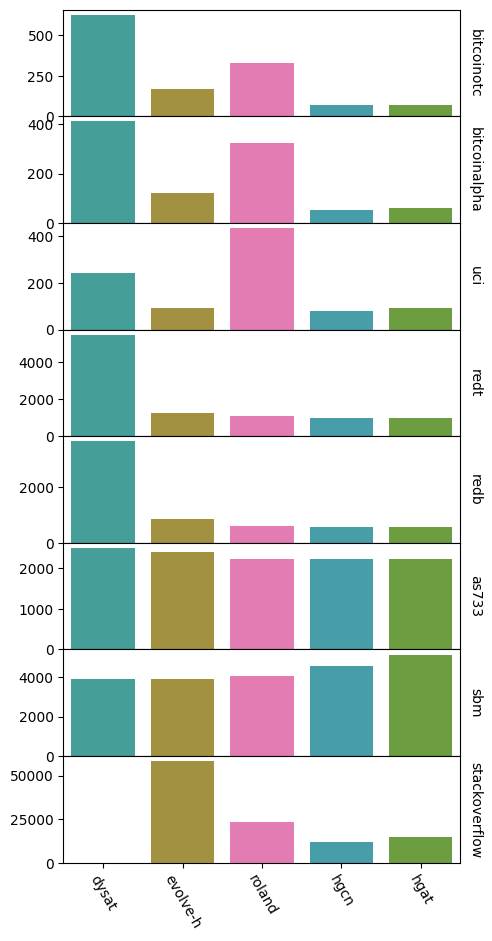

In [17]:

hue_order = [
    'dysat', 'evolve-h',  'roland', 'hgcn', 'hgat',
]

g1 = sbn.FacetGrid(df.query('type == "main"'), row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="gpu_mem", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < df.dataset.nunique():
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("GPU Mem(M)")
#g1.fig.suptitle('GPU Mem (MB)')
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.set_xlabels("")

/tmp/ipykernel_2408233/2199343372.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
/tmp/ipykernel_2408233/2199343372.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['UCI','Reddit-Title', 'Reddit-Body', 'AS733', 'SBM', 'StackOverflow'], rotation=-20)


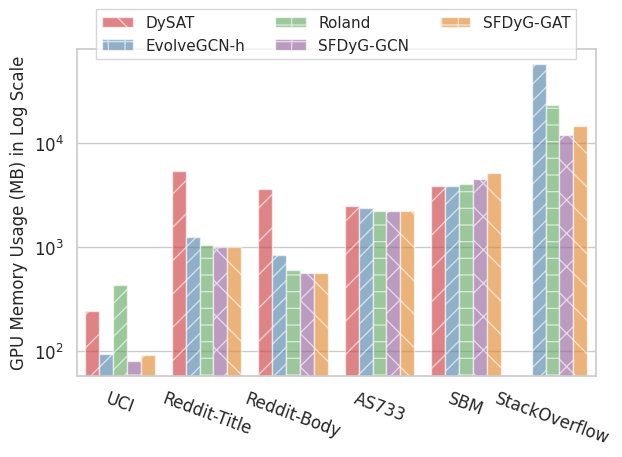

In [123]:
# https://stackoverflow.com/questions/42185000/add-hash-pattern-to-a-seaborn-bar-plot
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

hue_order = [
    'dysat', 'evolve-h',  'roland', 'hgcn', 'hgat',
]

row_order = ['uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']


ax = sbn.barplot(
    data=df.query(f'type == "main" and model in {hue_order} and dataset in {row_order}').sort_values(by='dataset'),
    x="dataset", y="gpu_mem", hue="model", hue_order=hue_order, order=row_order,
    errorbar="sd", alpha=.6, palette='Set1'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
ax.set_xticklabels(['UCI','Reddit-Title', 'Reddit-Body', 'AS733', 'SBM', 'StackOverflow'], rotation=-20)


num_locations = len(row_order)
hatches = itertools.cycle(['/', '//', '-', 'x', '\\', '+','*', 'o', 'O', '.'])
for i, bar in enumerate(ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)

    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.145), ncol=3, fancybox=False, shadow=False)
new_labels = ['DySAT', 'EvolveGCN-h', 'Roland', 'SFDyG-GCN', 'SFDyG-GAT']
for t, l in zip(ax.get_legend().get_texts(), new_labels):
    t.set_text(l)
    
ax.set_xlabel("")
ax.set_ylabel("GPU Memory Usage (MB) in Log Scale")
plt.yscale('log')
plt.yticks( size = 12)
plt.xticks( size = 12)
plt.tight_layout()
plt.savefig('gpu_usage.pdf', format='pdf', dpi=360)

# Mini-batch

In [19]:
df.dataset.unique()


array(['sbm', 'stackoverflow', 'redb', 'uci', 'bitcoinalpha', 'as733',
       'bitcoinotc', 'redt'], dtype=object)

In [213]:
model = [
    'hgcn', 'hgat'
]
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb',   'as733', 'stackoverflow', 'sbm',]
b_map = {
    'dysat': '\\texttt{DySAT}',
    'evolve-h': '\\texttt{EvolveGCN-h}',
    'evolve-o': '\\texttt{EvolveGCN-o}',
    'vgrnn': '\\texttt{VGRNN}',
    'htgn': '\\texttt{HTGN}',
    'wingnn': '\\texttt{WinGNN}',
    'roland': '\\texttt{Roland}',
    'hgcn': '\\texttt{SFDyG-GCN}',
    'hgat': '\\texttt{SFDyG-GAT}',
}
d_map = {
    'as733': 'AS733',
    'redt': 'Reddit-Title', 
    'redb': 'Reddit-Body', 
    'bitcoinalpha': 'Alpha', 
    'bitcoinotc': 'OTC', 
    'sbm': 'SBM',
    'uci': 'UCI', 
    'stackoverflow': 'SO'
}
types = ["main", 'mini']
sf=df.query(f'type in {types} and model in {model}')
mrr_table = []
# for model in hue_order:
#     print(model)
for ds in row_order:
    # fb = sf.query(f'model == "{model[0]}" and dataset == "{ds}" and type == "main"')
    # mb = sf.query(f'model == "{model[0]}" and dataset == "{ds}" and type == "mini"')
    # fb_avg = fb['mrr_mean'].values[0]
    # mb_avg = mb['mrr_mean'].values[0]

    # # fb_val = f"{fb_avg*100:.2f} $\pm$ {fb_std*100:.2f}"
    # # mb_val = f"{mb_avg*100:.2f} $\pm$ {mb_std*100:.2f}"
    # fb_val = f"{fb_avg*1:.4f}"
    # mb_val = f"{mb_avg*1:.4f}"
    # mrr_delta = np.abs(fb_avg - mb_avg) / fb_avg * 100
    
    # fb_mem = fb['gpu_mem'].values[0]
    # mb_mem = mb['gpu_mem'].values[0]
    # mem_delta = np.abs(fb_mem - mb_mem) / fb_mem * 100
    
    # sign1 = '\\downarrow' if fb_avg > mb_avg else '\\uparrow'
    # sign2 = '\\downarrow' if fb_mem > mb_mem else '\\uparrow'
    # #mrr_table.append(d_map[ds] + '   &' + fb_val + '  &  ' +  mb_val + '  &  ' + f'${sign}$ {delta:.2f}' + '    \\\\')
    # gcn_str = f'{fb_val}  &  {mb_val}  & ${sign1}$ {mrr_delta:.2f}\\%  & ${sign2}$ {mem_delta:.2f}\\%'


    fb = sf.query(f'model == "{model[1]}" and dataset == "{ds}" and type == "main"')
    mb = sf.query(f'model == "{model[1]}" and dataset == "{ds}" and type == "mini"')
    fb_avg = fb['mrr_mean'].values[0]
    mb_avg = mb['mrr_mean'].values[0]
    fb_std = fb['mrr_std'].values[0]
    mb_std = mb['mrr_std'].values[0]

    fb_val = f"{fb_avg*100:.2f} $\pm$ {fb_std*100:.2f}"
    mb_val = f"{mb_avg*100:.2f} $\pm$ {mb_std*100:.2f}"
    #fb_val = f"{fb_avg*1:.4f}"
    #mb_val = f"{mb_avg*1:.4f}"
    mrr_delta = np.abs(fb_avg - mb_avg) / fb_avg * 100
    
    fb_mem = fb['gpu_mem'].values[0]
    mb_mem = mb['gpu_mem'].values[0]
    mem_delta = np.abs(fb_mem - mb_mem) / fb_mem * 100
    
    sign1 = '\\downarrow' if fb_avg > mb_avg else '\\uparrow'
    sign2 = '\\downarrow' if fb_mem > mb_mem else '\\uparrow'
    gat_str = f'{fb_val}  &  {mb_val}  & ${sign1}$ {mrr_delta:.2f}\\%  & ${sign2}$ {mem_delta:.2f}\\%'
    
    mrr_table.append(f'{d_map[ds]}  & {gat_str}  \\\\') # & {gcn_str} 
    print(mrr_table[-1])


OTC  & 51.34 $\pm$ 0.07  &  52.59 $\pm$ 1.49  & $\uparrow$ 2.43\%  & $\downarrow$ 4.13\%  \\
Alpha  & 40.66 $\pm$ 0.25  &  40.61 $\pm$ 0.19  & $\downarrow$ 0.12\%  & $\downarrow$ 13.01\%  \\
UCI  & 35.59 $\pm$ 1.58  &  39.00 $\pm$ 0.11  & $\uparrow$ 9.58\%  & $\downarrow$ 0.67\%  \\
Reddit-Title  & 50.84 $\pm$ 0.05  &  51.17 $\pm$ 0.17  & $\uparrow$ 0.65\%  & $\downarrow$ 6.59\%  \\
Reddit-Body  & 40.97 $\pm$ 0.47  &  41.87 $\pm$ 0.18  & $\uparrow$ 2.20\%  & $\downarrow$ 7.78\%  \\
AS733  & 45.95 $\pm$ 0.79  &  52.59 $\pm$ 1.18  & $\uparrow$ 14.45\%  & $\downarrow$ 2.03\%  \\
SO  & 48.83 $\pm$ 0.14  &  47.84 $\pm$ 0.05  & $\downarrow$ 2.03\%  & $\downarrow$ 44.01\%  \\
SBM  & 28.96 $\pm$ 0.70  &  29.45 $\pm$ 0.54  & $\uparrow$ 1.69\%  & $\uparrow$ 0.19\%  \\


<>:60: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:60: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2408233/4241186942.py:60: SyntaxWarning: invalid escape sequence '\p'
  fb_val = f"{fb_avg*100:.2f} $\pm$ {fb_std*100:.2f}"
/tmp/ipykernel_2408233/4241186942.py:61: SyntaxWarning: invalid escape sequence '\p'
  mb_val = f"{mb_avg*100:.2f} $\pm$ {mb_std*100:.2f}"


In [214]:
sf

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
2,stackoverflow,hgat,8211.86,369.89,9370.54,0.4784,0.3543,0.5415,0.7363,0.8356,0.8737,0.0005,0.0016,0.0022,0.0086,0.0004,0.0002,mini,,0.0
14,bitcoinalpha,hgat,52.04,6.07,214.39,0.4061,0.2726,0.4852,0.6743,0.8182,0.8173,0.0019,0.0057,0.0037,0.0064,0.0035,0.0041,mini,,0.0
68,redb,hgat,559.14,6.69,334.43,0.4097,0.2826,0.4653,0.6671,0.8499,0.8720,0.0047,0.0062,0.0036,0.0019,0.0016,0.0013,main,,0.0
108,bitcoinotc,hgcn,72.13,1.85,74.61,0.4616,0.2464,0.5860,0.9364,0.9540,0.9454,0.0045,0.0078,0.0045,0.0000,0.0000,0.0005,main,,0.0
117,redb,hgcn,559.53,6.07,303.45,0.3644,0.2309,0.4071,0.6594,0.8571,0.8684,0.0042,0.0053,0.0058,0.0012,0.0013,0.0010,main,,0.0
120,as733,hgcn,2210.84,5.92,181.60,0.4434,0.3323,0.4816,0.6547,0.8999,0.8729,0.0041,0.0194,0.0161,0.0686,0.0250,0.0259,main,,0.0
141,uci,hgcn,80.09,9.02,189.40,0.3194,0.1866,0.3731,0.6199,0.8009,0.7977,0.0003,0.0010,0.0010,0.0009,0.0001,0.0002,mini,,0.0
171,uci,hgcn,80.27,1.69,77.06,0.3561,0.1876,0.4076,0.7617,0.9433,0.9285,0.0006,0.0022,0.0040,0.0013,0.0001,0.0006,main,,0.0
185,redb,hgat,515.64,124.43,6221.49,0.4187,0.2936,0.4750,0.6685,0.8478,0.8723,0.0018,0.0023,0.0018,0.0012,0.0011,0.0004,mini,,0.0
187,stackoverflow,hgat,14666.09,39.78,1869.71,0.4883,0.3604,0.5570,0.7581,0.8372,0.8767,0.0014,0.0017,0.0028,0.0065,0.0023,0.0015,main,,0.0


# Ablation

In [125]:
hue_order = ['gat', 'hgat']
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
sf=df.query(f'(type == "main") and model in {hue_order}') #  or (type == "exp" and exp_name == "nobn")
sf.sort_values(by=["dataset", "model"])[['dataset', 'model', 'mrr_mean', 'mrr_std', 'type', 'exp_name']]

,dataset,model,mrr_mean,mrr_std,type,exp_name
554,as733,gat,0.2262,0.0104,main,
226,as733,hgat,0.4595,0.0079,main,
241,bitcoinalpha,gat,0.0968,0.0317,main,
262,bitcoinalpha,hgat,0.4066,0.0025,main,
242,bitcoinotc,gat,0.1518,0.0763,main,
407,bitcoinotc,hgat,0.5134,0.0007,main,
528,redb,gat,0.1233,0.0222,main,
64,redb,hgat,0.4097,0.0047,main,
736,redt,gat,0.1787,0.0240,main,
437,redt,hgat,0.5084,0.0005,main,


In [126]:
for ds in row_order:
    gat = sf.query(f'model == "gat" and dataset == "{ds}"')
    hgat = sf.query(f'model == "hgat" and dataset == "{ds}"')
    gat_avg = gat['mrr_mean'].values[0]
    hgat_avg = hgat['mrr_mean'].values[0]
    gat_std = gat['mrr_std'].values[0]
    hgat_std = hgat['mrr_std'].values[0]

    gat_val = f"{gat_avg*100:.2f} $\pm$ {gat_std*100:.2f}"
    hgat_val = f"{hgat_avg*100:.2f} $\pm$ {hgat_std*100:.2f}"

    delta = (hgat_avg - gat_avg) / gat_avg * 100
    row_str = f'{d_map[ds]} &  {gat_val}  &  {hgat_val}  & {delta:.2f}\\%  \\\\'
    print(row_str)
print()
hue_order = ['gcn', 'hgcn']
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
sf=df.query(f'(type == "main") and model in {hue_order}') #  or (type == "exp" and exp_name == "nobn")
sf.sort_values(by=["dataset", "model"])[['dataset', 'model', 'mrr_mean', 'mrr_std', 'type', 'exp_name']]
for ds in row_order:
    gat = sf.query(f'model == "gcn" and dataset == "{ds}"')
    hgat = sf.query(f'model == "hgcn" and dataset == "{ds}"')
    gat_avg = gat['mrr_mean'].values[0]
    hgat_avg = hgat['mrr_mean'].values[0]
    gat_std = gat['mrr_std'].values[0]
    hgat_std = hgat['mrr_std'].values[0]

    gat_val = f"{gat_avg*100:.2f} $\pm$ {gat_std*100:.2f}"
    hgat_val = f"{hgat_avg*100:.2f} $\pm$ {hgat_std*100:.2f}"

    delta = (hgat_avg - gat_avg) / gat_avg * 100
    row_str = f'{d_map[ds]} &  {gat_val}  &  {hgat_val}  & {delta:.2f}\\%  \\\\'
    print(row_str)

OTC &  15.18 $\pm$ 7.63  &  51.34 $\pm$ 0.07  & 238.21\%  \\
Alpha &  9.68 $\pm$ 3.17  &  40.66 $\pm$ 0.25  & 320.04\%  \\
UCI &  15.98 $\pm$ 4.06  &  35.59 $\pm$ 1.58  & 122.72\%  \\
Reddit-Title &  17.87 $\pm$ 2.40  &  50.84 $\pm$ 0.05  & 184.50\%  \\
Reddit-Body &  12.33 $\pm$ 2.22  &  40.97 $\pm$ 0.47  & 232.28\%  \\
AS733 &  22.62 $\pm$ 1.04  &  45.95 $\pm$ 0.79  & 103.14\%  \\
SBM &  3.78 $\pm$ 1.87  &  28.96 $\pm$ 0.70  & 666.14\%  \\
SO &  22.39 $\pm$ 2.48  &  48.83 $\pm$ 0.14  & 118.09\%  \\

OTC &  13.15 $\pm$ 0.26  &  46.16 $\pm$ 0.45  & 251.03\%  \\
Alpha &  8.50 $\pm$ 0.27  &  47.87 $\pm$ 5.85  & 463.18\%  \\
UCI &  10.71 $\pm$ 0.06  &  35.61 $\pm$ 0.06  & 232.49\%  \\
Reddit-Title &  36.03 $\pm$ 0.03  &  47.44 $\pm$ 0.20  & 31.67\%  \\
Reddit-Body &  21.72 $\pm$ 0.01  &  36.44 $\pm$ 0.42  & 67.77\%  \\
AS733 &  49.29 $\pm$ 0.06  &  44.34 $\pm$ 0.41  & -10.04\%  \\
SBM &  26.91 $\pm$ 0.46  &  29.10 $\pm$ 0.73  & 8.14\%  \\
SO &  37.52 $\pm$ 2.45  &  46.41 $\pm$ 0.31  & 23.

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2408233/496298405.py:9: SyntaxWarning: invalid escape sequence '\p'
  gat_val = f"{gat_avg*100:.2f} $\pm$ {gat_std*100:.2f}"
/tmp/ipykernel_2408233/496298405.py:10: SyntaxWarning: invalid escape sequence '\p'
  hgat_val = f"{hgat_avg*100:.2f} $\pm$ {hgat_std*100:.2f}"
/tmp/ipykernel_2408233/496298405.py:28: SyntaxWarning: invalid escape sequence '\p'
  gat_val = f"{gat_avg*100:.2f} $\pm$ {gat_std*100:.2f}"
/tmp/ipykernel_2408233/496298405.py:29: SyntaxWarning: invalid escape sequence '\p'
  hgat_val = f"{hgat_avg*100:.2f} $\pm$ {hgat_std*100:.2f}"


In [24]:
sf

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
1,sbm,gcn,2462.81,3.42,103.77,0.2691,0.2237,0.2619,0.3346,0.6415,0.6172,0.0046,0.0065,0.0027,0.0044,0.0388,0.0148,main,,0.0
37,redb,gcn,556.72,4.27,89.61,0.2172,0.1653,0.2071,0.2880,0.6504,0.6666,0.0001,0.0001,0.0000,0.0004,0.0025,0.0016,main,,0.0
83,uci,gcn,51.42,1.39,53.32,0.1071,0.0630,0.0813,0.1619,0.5232,0.5793,0.0006,0.0010,0.0000,0.0028,0.0002,0.0011,main,,0.0
102,bitcoinotc,hgcn,72.13,1.85,74.61,0.4616,0.2464,0.5860,0.9364,0.9540,0.9454,0.0045,0.0078,0.0045,0.0000,0.0000,0.0005,main,,0.0
111,redb,hgcn,559.53,6.07,303.45,0.3644,0.2309,0.4071,0.6594,0.8571,0.8684,0.0042,0.0053,0.0058,0.0012,0.0013,0.0010,main,,0.0
113,as733,hgcn,2210.84,5.92,181.60,0.4434,0.3323,0.4816,0.6547,0.8999,0.8729,0.0041,0.0194,0.0161,0.0686,0.0250,0.0259,main,,0.0
131,bitcoinalpha,gcn,52.85,2.23,72.01,0.0850,0.0433,0.0569,0.1450,0.4719,0.5216,0.0027,0.0032,0.0037,0.0092,0.0014,0.0023,main,,0.0
145,redt,gcn,1000.97,5.36,119.69,0.3603,0.3116,0.3733,0.4114,0.6619,0.7080,0.0003,0.0002,0.0018,0.0007,0.0039,0.0009,main,,0.0
161,uci,hgcn,80.27,1.69,77.06,0.3561,0.1876,0.4076,0.7617,0.9433,0.9285,0.0006,0.0022,0.0040,0.0013,0.0001,0.0006,main,,0.0
345,sbm,hgcn,4538.85,8.56,370.83,0.2910,0.2481,0.2797,0.3485,0.7046,0.6439,0.0073,0.0093,0.0078,0.0041,0.0107,0.0062,main,,0.0


# Hyper parameter

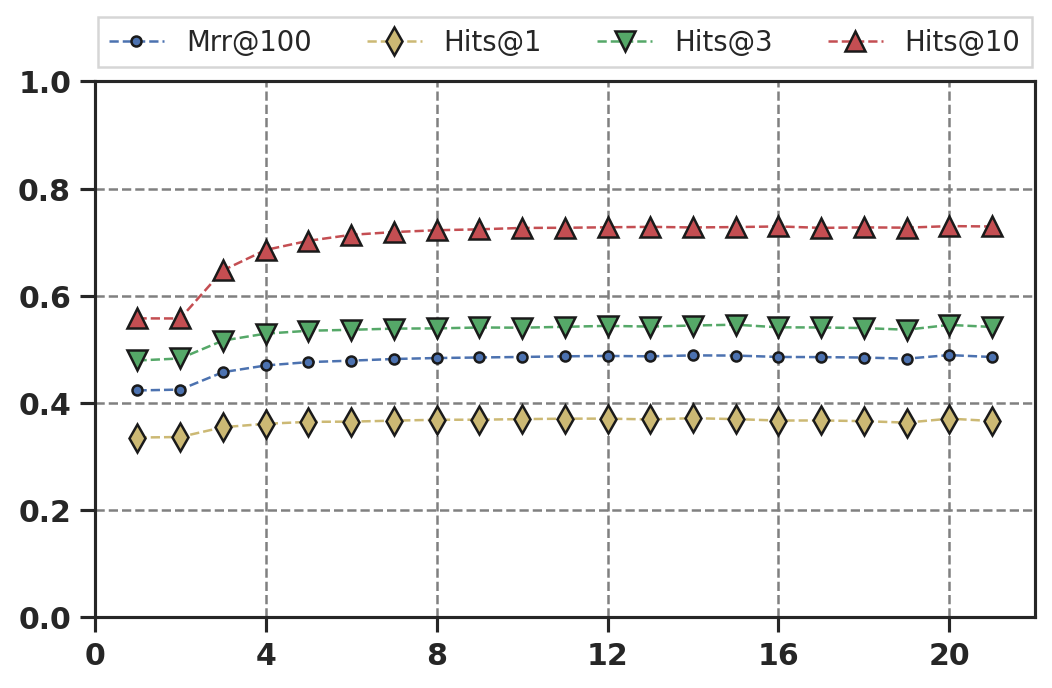

In [173]:
import matplotlib.pyplot as plt
sf = df[(df.type=='exp') & (df.exp_name=='window') & (df.dataset == 'redt')].sort_values(by='exp_param').reset_index()
custom_params = {"grid.linewidth":1, 'grid.color': 'gray', 'grid.linestyle': '--'}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(6.2, 4), dpi=180)
plt.plot(sf.exp_param, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='Mrr@100')
plt.plot(sf.exp_param, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(sf.exp_param, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(sf.exp_param, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend(bbox_to_anchor=(1,0.7), loc="upper left", fontsize=14)
ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.145), ncol=4, fancybox=False, shadow=False)
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0, 21, 4))
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.tight_layout()
plt.savefig('hp_win.pdf', format='pdf', dpi=360)

In [130]:
sf

,index,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,...,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
0,664,uci,hgat,51.48,0.68,25.08,0.6302,0.4087,0.8342,1.0000,...,0.9827,0.0004,0.0009,0.0000,0.0000,0.0000,0.0000,exp,window,1.0
1,147,uci,hgat,51.48,0.67,26.85,0.6310,0.4108,0.8335,1.0000,...,0.9740,0.0001,0.0000,0.0005,0.0000,0.0000,0.0001,exp,window,2.0
2,403,uci,hgat,51.93,0.68,17.40,0.4994,0.2767,0.6360,0.9926,...,0.9817,0.0006,0.0015,0.0013,0.0000,0.0000,0.0000,exp,window,3.0
3,590,uci,hgat,51.85,0.67,22.63,0.4373,0.2228,0.5255,0.9799,...,0.9690,0.0013,0.0026,0.0005,0.0000,0.0000,0.0001,exp,window,4.0
4,642,uci,hgat,57.39,0.66,23.40,0.4280,0.2383,0.4935,0.9493,...,0.9611,0.0003,0.0005,0.0010,0.0000,0.0001,0.0001,exp,window,5.0
5,150,uci,hgat,64.99,0.63,28.77,0.4015,0.2186,0.4516,0.8944,...,0.9427,0.0006,0.0015,0.0013,0.0000,0.0001,0.0003,exp,window,6.0
6,523,uci,hgat,72.05,0.64,16.48,0.3961,0.2207,0.4393,0.8662,...,0.9340,0.0026,0.0043,0.0017,0.0010,0.0001,0.0002,exp,window,7.0
7,506,uci,hgat,77.07,0.63,17.95,0.3781,0.2042,0.4203,0.8145,...,0.9341,0.0021,0.0033,0.0009,0.0005,0.0003,0.0008,exp,window,8.0
8,52,uci,hgat,84.12,0.61,18.78,0.3690,0.1982,0.4076,0.8039,...,0.9171,0.0008,0.0022,0.0038,0.0005,0.0001,0.0004,exp,window,9.0
9,398,uci,hgat,91.63,0.62,19.59,0.3634,0.2094,0.4122,0.7226,...,0.8899,0.0098,0.0144,0.0100,0.0675,0.1338,0.0602,exp,window,10.0


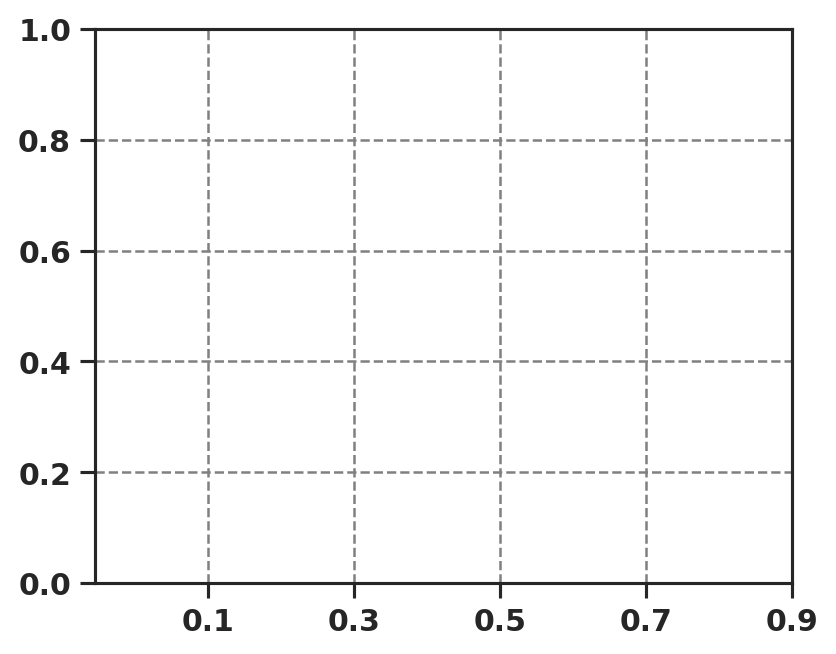

In [26]:
sf = df[(df.type=='exp') & (df.exp_name=='dropout')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
plt.plot(sf.exp_param*0.1, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(sf.exp_param*0.1, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(sf.exp_param*0.1, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(sf.exp_param*0.1, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0.1, 1, 0.2))
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_dropout.pdf', format='pdf', dpi=360)

/tmp/ipykernel_2408233/2203623168.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 1,2,4,8,16])


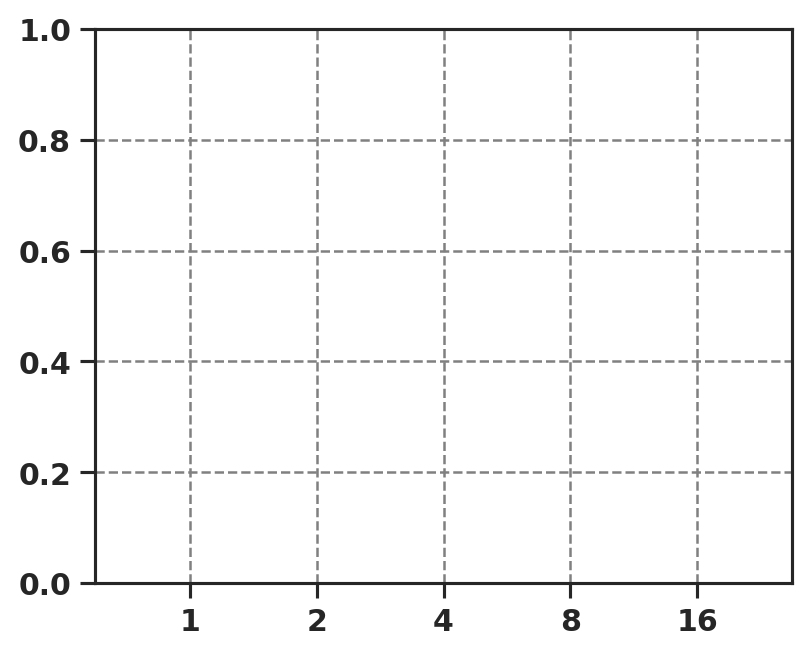

In [27]:
sf = df[(df.type=='exp') & (df.exp_name=='heads')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels([0, 1,2,4,8,16]) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_heads.pdf', format='pdf', dpi=360)

/tmp/ipykernel_2408233/3376847025.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()])


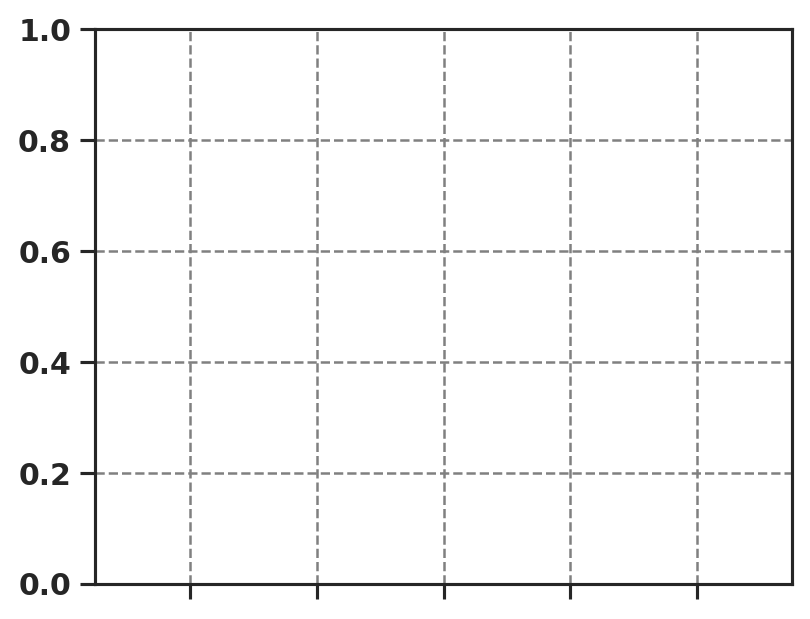

In [28]:
sf = df[(df.type=='exp') & (df.exp_name=='hidden')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()]) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_hidden.pdf', format='pdf', dpi=360)

In [223]:
import os

class ParseNegExperimentLog():
    def __init__(self):
        pass

    def parse_line(self, line, pos):
        return line.strip().split(' ')[pos]

    def read_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            #print(file_path)
            if len(lines) > 48:
                if len(lines) % 48 == 0:
                    lines = lines[-48:]
                else:
                    lines = lines[-50:]
            runs = int(self.parse_line(lines[10], -1))
            ds = self.parse_line(lines[1], -1)
            model = self.parse_line(lines[2], -1)
            
            exp_name = ''
            exp_param = 0

            exp_name = file_path.split('.', 1)[1][:-4]
            if exp_name.startswith('window-') or  exp_name.startswith('dropout-') \
            or exp_name.startswith('heads-') or  exp_name.startswith('hidden-') \
            or exp_name.startswith('learnrate-') or  exp_name.startswith('n_neg_train-'):
                arr = exp_name.split('-')
                exp_name = arr[0]
                exp_param = arr[1]

            for i in range(runs):
                mrr = float(lines[39+i][12:].split(',')[0])
                yield {
                    'dataset': ds,
                    'model': model,
                    'mrr_mean': mrr,
                    'exp_name': exp_name,
                    'exp_param': float(exp_param),
                }
    
    def read_all(self, log_path='log', mod='hgat'):
        records = []
        for file in os.listdir(log_path): 
            if file.startswith(f'Exp_{mod}') and file.endswith(".log") and 'n_neg_train' in file: 
                file_path = f"log/{file}"
                for rr in self.read_file(file_path):
                    records.append(rr)
        return pd.DataFrame(records)

parser = ParseNegExperimentLog()
tnf = parser.read_all()
tnf

,dataset,model,mrr_mean,exp_name,exp_param
0,redb,hgat,0.414951,n_neg_train,6.0
1,redb,hgat,0.405890,n_neg_train,6.0
2,redb,hgat,0.415995,n_neg_train,6.0
3,stackoverflow,hgat,0.494388,n_neg_train,5.0
4,stackoverflow,hgat,0.487032,n_neg_train,5.0
...,...,...,...,...,...
279,redt,hgat,0.506637,n_neg_train,20.0
280,redt,hgat,0.507360,n_neg_train,20.0
281,redb,hgat,0.413334,n_neg_train,4.0
282,redb,hgat,0.406512,n_neg_train,4.0


/tmp/ipykernel_2408233/3631357500.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, weight='bold')
/tmp/ipykernel_2408233/3631357500.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')


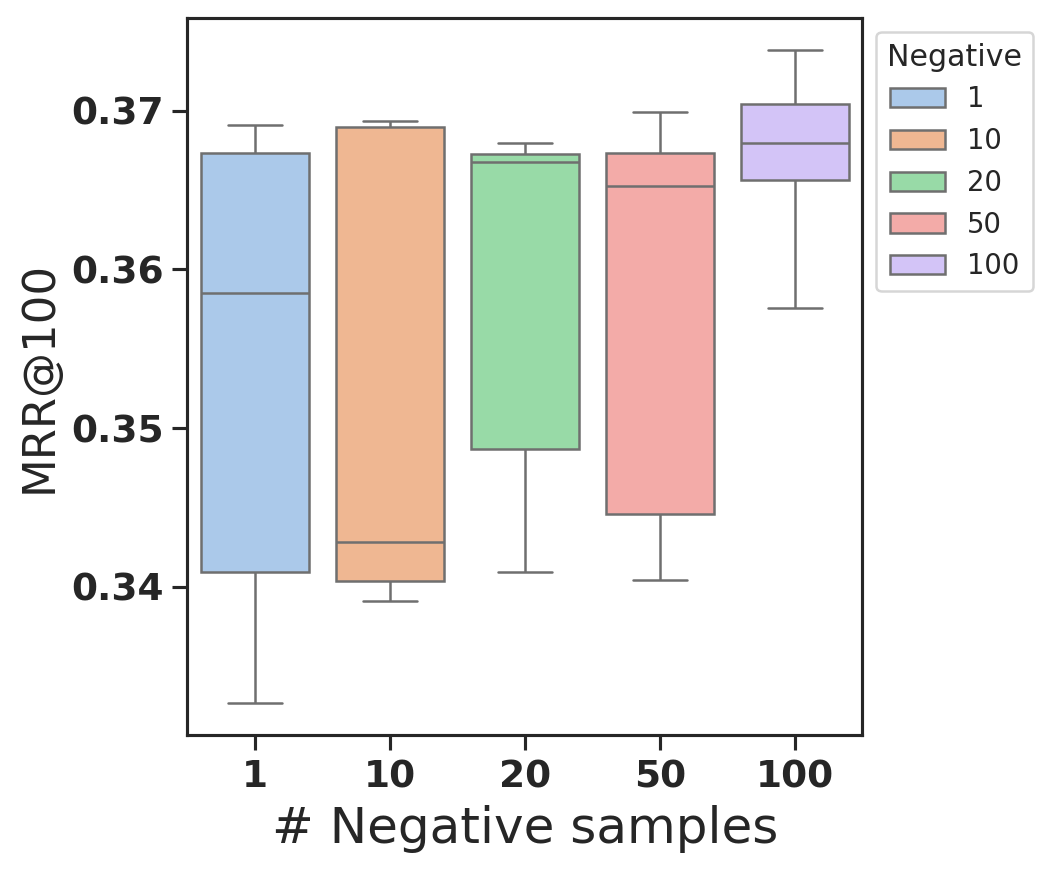

In [224]:

neg_train_data = [
[0.3409316,1],
[0.3673237,1],
[0.3326808,1],
[0.3585065,1],
[0.3690817,1],
[0.3693306,10],
[0.3689906,10],
[0.3427934,10],
[0.3390577,10],
[0.3403471,10],
[0.3486619,20],
[0.3679741,20],
[0.3408884,20],
[0.367252,20],
[0.3667484,20],
[0.365232,50],
[0.3404013,50],
[0.3445912,50],
[0.3673186,50],
[0.3698995,50],
[0.3575405,100],
[0.3704099,100],
[0.3679302,100],
[0.3737913,100],
[0.3656274,100],
]
neg_df = pd.DataFrame(neg_train_data)
neg_df.columns = ['val', 'Negative']

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=180)
ax = sns.boxplot(neg_df, x='Negative', y='val', whis=100, hue='Negative', palette='pastel', ax=ax)
#ax.set_ylim([0.5, 0.55])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xlabel('# Negative samples')
ax.set_ylabel('MRR@100')


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')

plt.tight_layout()
# plt.yticks(weight='bold', size = 12)
# plt.xticks(weight='bold', size = 12)
plt.savefig('hgat_uci_neg.pdf', format='pdf', dpi=360)

/tmp/ipykernel_2408233/467352074.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=10, weight='bold')
/tmp/ipykernel_2408233/467352074.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10, weight='bold')
/tmp/ipykernel_2408233/467352074.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=10, weight='bold')


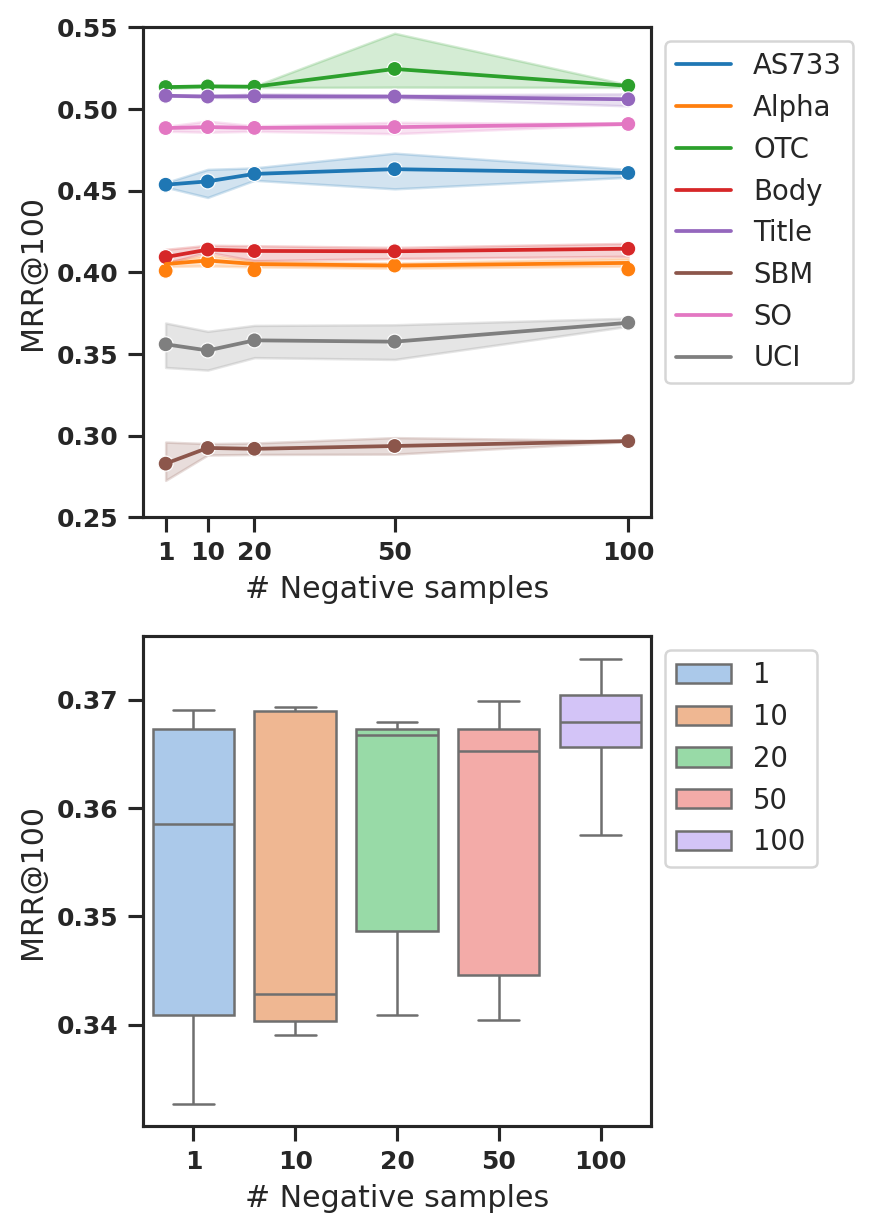

In [238]:
import matplotlib.pyplot as plt
custom_params = {"grid.linewidth":1, 'grid.color': 'gray', 'grid.linestyle': '--'}
sns.set_theme(style="ticks", rc=custom_params)
#plt.figure(figsize=(6.2, 4), dpi=180)

D_NAME = {
    'bitcoinotc': 'OTC', 'sbm': 'SBM', 'bitcoinalpha': 'Alpha', 'uci': 'UCI', 'redb': 'Body', 'redt': 'Title',
    'as733': "AS733", 'stackoverflow': 'SO'
}
sf = df.query('type=="exp" and exp_name=="n_neg_train" and model=="hgat" and exp_param in (1, 10, 20, 50,100)' ).sort_values(by='dataset').reset_index()
nf = tnf.query('exp_param in (1, 10, 20, 50, 100)' ).sort_values(by='dataset').reset_index()
sf['Dataset'] = sf['dataset'].apply(lambda x: D_NAME[x])
nf['Dataset'] = nf['dataset'].apply(lambda x: D_NAME[x])

fig, ax = plt.subplots(2, 1, figsize=(5, 7), dpi=180)
gfg = sbn.lineplot(nf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', ax=ax[0])
sbn.scatterplot(sf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', legend=False, ax=ax[0], marker='o')
gfg.legend_.set_title(None)

#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
#sns.move_legend(ax[0], "lower right", ncol=3)

# for legend text
plt.setp(gfg.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(gfg.get_legend().get_title(), fontsize='14')  
ax[0].set_ylim([0.25, 0.55])
ax[0].set_xticks([1, 10, 20, 50, 100]) 



#plt.legend()
#ax = plt.gca()
# plt.grid()

gbg = sns.boxplot(neg_df, x='Negative', y='val', whis=100, hue='Negative', palette='pastel', ax=ax[1])
#sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
#sns.move_legend(ax[1], "lower right", ncol=3)
gbg.legend_.set_title(None)


# for legend text
plt.setp(gbg.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(gbg.get_legend().get_title(), fontsize='14')  

for i in range(2):
    ax[i].set_xlabel('# Negative samples')
    ax[i].set_ylabel('MRR@100')
    #handles, labels = ax[i].get_legend_handles_labels()
    #ax[i].legend(handles=handles[1:], labels=labels[1:])

    ax[i].xaxis.label.set_size(12)
    ax[i].yaxis.label.set_size(12)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10, weight='bold')
    ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=10, weight='bold')
    sns.move_legend(ax[i], "upper left", bbox_to_anchor=(1, 1))



plt.tight_layout()
# plt.yticks(weight='bold', size = 12)
# plt.xticks(weight='bold', size = 12)
plt.savefig('hgat_ktrain_new.pdf', format='pdf', dpi=360)

/tmp/ipykernel_2408233/549704968.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')


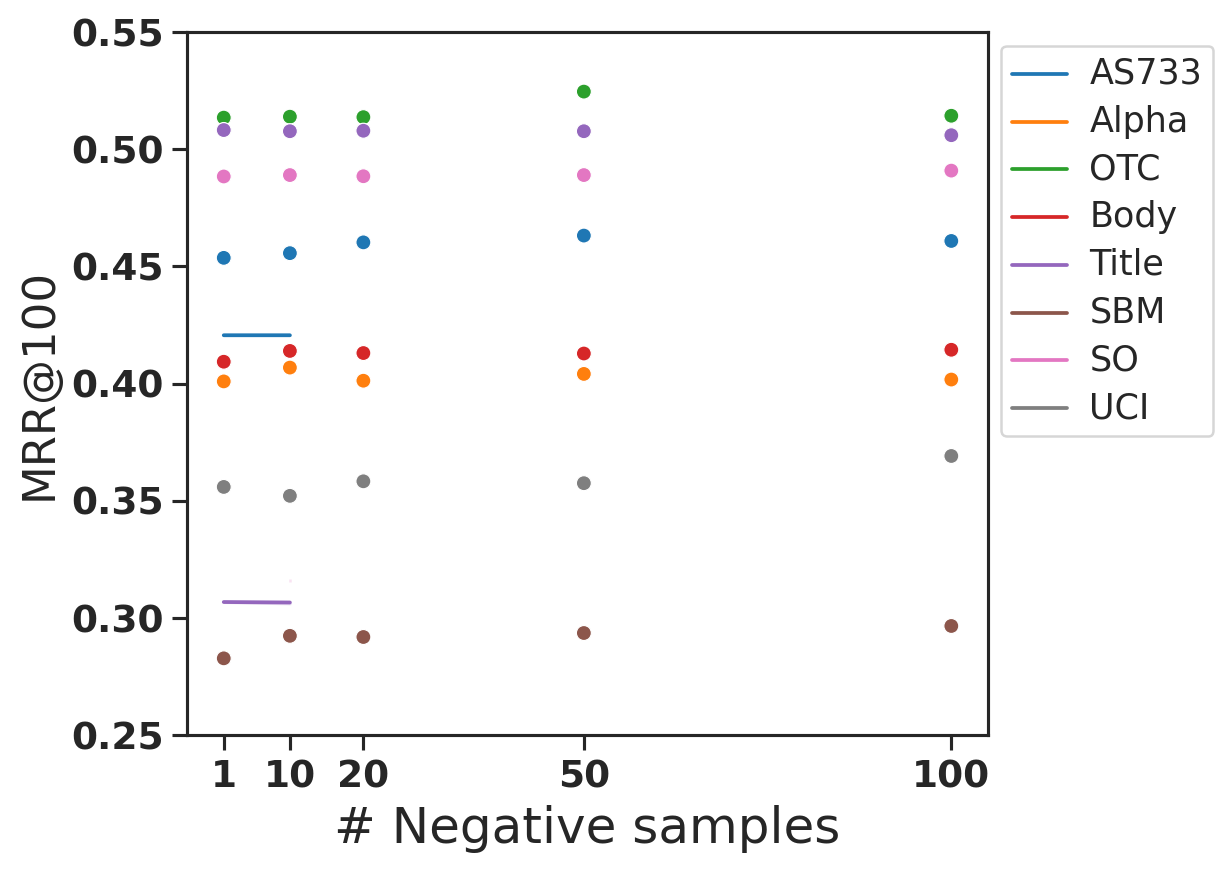

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=180)
gfg = sbn.lineplot(nf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', ax=ax)
sbn.scatterplot(sf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', legend=False, ax=ax, marker='o')
gfg.legend_.set_title(None)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# for legend text
plt.setp(gfg.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(gfg.get_legend().get_title(), fontsize='14')  
ax.set_ylim([0.25, 0.55])
ax.set_xticks([1, 10, 20, 50, 100])

ax.set_xlabel('# Negative samples')
ax.set_ylabel('MRR@100')


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')

plt.tight_layout()
# plt.yticks(weight='bold', size = 12)
# plt.xticks(weight='bold', size = 12)
plt.savefig('hgat_ktrain.pdf', format='pdf', dpi=360)

/tmp/ipykernel_2408233/1743132999.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, weight='bold')
/tmp/ipykernel_2408233/1743132999.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')


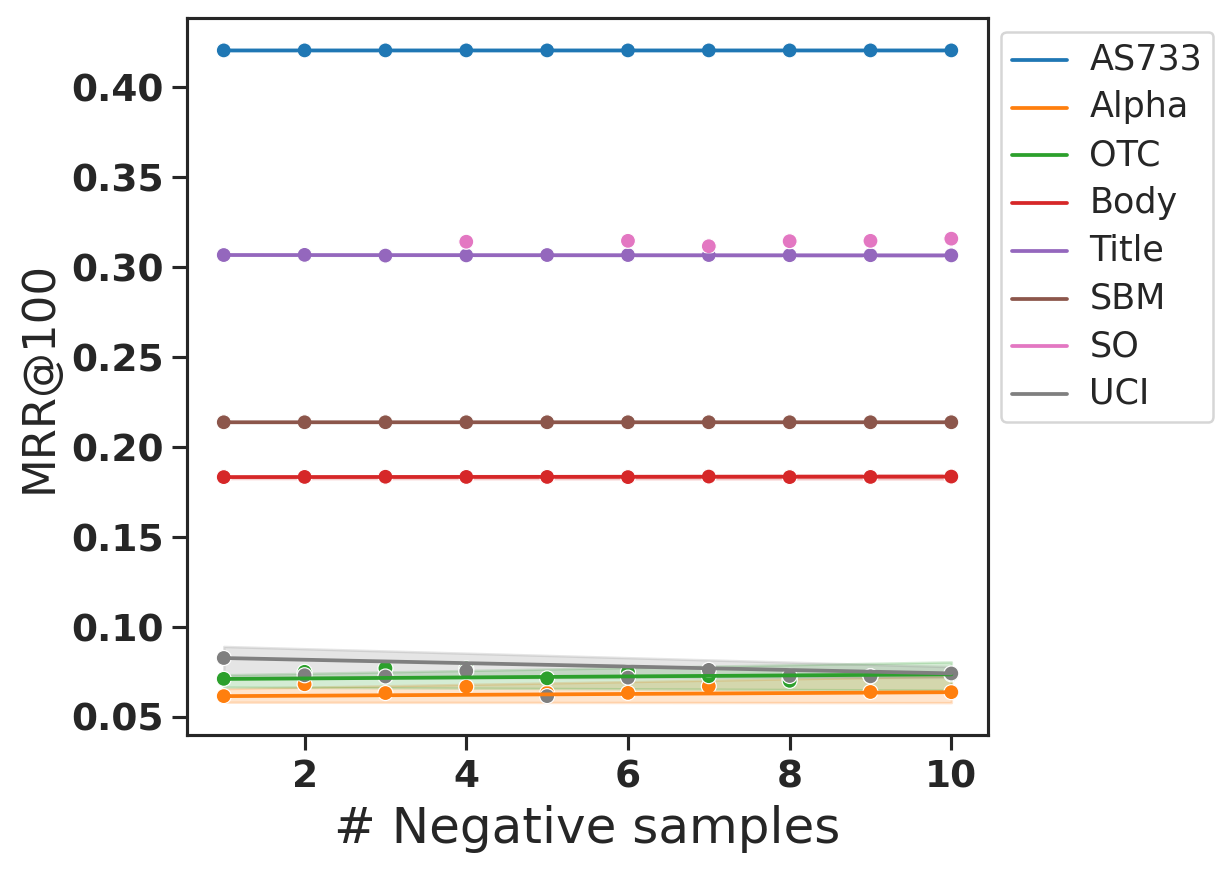

In [187]:

parser = ParseNegExperimentLog()
tnf = parser.read_all(mod='evolve-h')
tnf

D_NAME = {
    'bitcoinotc': 'OTC', 'sbm': 'SBM', 'bitcoinalpha': 'Alpha', 'uci': 'UCI', 'redb': 'Body', 'redt': 'Title',
    'as733': "AS733", 'stackoverflow': 'SO'
}
sf = df.query('type=="exp" and exp_name=="n_neg_train" and model=="evolve-h"' ).sort_values(by='dataset').reset_index()
nf = tnf.query('exp_param in (1, 10, 20, 50, 100)' ).sort_values(by='dataset').reset_index()
sf['Dataset'] = sf['dataset'].apply(lambda x: D_NAME[x])
nf['Dataset'] = nf['dataset'].apply(lambda x: D_NAME[x])

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=180)
gfg = sbn.lineplot(nf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', ax=ax)
sbn.scatterplot(sf, x='exp_param', y='mrr_mean', hue='Dataset', palette='tab10', legend=False, ax=ax, marker='o')
gfg.legend_.set_title(None)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# for legend text
plt.setp(gfg.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(gfg.get_legend().get_title(), fontsize='14')  
# ax.set_ylim([0.25, 0.55])
# ax.set_xticks([1, 10, 20, 50, 100])

ax.set_xlabel('# Negative samples')
ax.set_ylabel('MRR@100')


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, weight='bold')

plt.tight_layout()
# plt.yticks(weight='bold', size = 12)
# plt.xticks(weight='bold', size = 12)
plt.savefig('hgat_ktrain.pdf', format='pdf', dpi=360)

In [183]:
sf

,index,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,...,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param,Dataset
0,289,as733,evolve-o,2391.79,19.12,401.45,0.4206,0.3570,0.4556,0.4999,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,2.0,AS733
1,714,as733,evolve-o,2391.29,18.13,380.65,0.4206,0.3570,0.4556,0.4999,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,7.0,AS733
2,204,as733,evolve-o,2392.15,9.76,205.05,0.4206,0.3570,0.4556,0.4999,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,10.0,AS733
3,316,as733,evolve-o,2391.29,14.34,305.88,0.4206,0.3570,0.4556,0.4999,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,6.0,AS733
4,667,as733,evolve-o,2392.16,17.01,357.15,0.4206,0.3570,0.4556,0.4999,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,exp,n_neg_train,3.0,AS733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,463,uci,evolve-o,103.68,9.17,385.30,0.0728,0.0297,0.0414,0.1460,...,0.0016,0.0015,0.0013,0.0005,0.0058,0.0040,exp,n_neg_train,7.0,UCI
71,466,uci,evolve-o,130.47,5.62,181.62,0.0806,0.0366,0.0506,0.1484,...,0.0060,0.0059,0.0084,0.0010,0.0074,0.0032,exp,n_neg_train,10.0,UCI
72,528,uci,evolve-o,92.39,9.25,317.65,0.0815,0.0349,0.0472,0.1586,...,0.0038,0.0050,0.0069,0.0184,0.0505,0.0374,exp,n_neg_train,2.0,UCI
73,678,uci,evolve-o,92.93,8.72,374.94,0.0732,0.0287,0.0403,0.1477,...,0.0007,0.0000,0.0005,0.0042,0.0152,0.0055,exp,n_neg_train,4.0,UCI


In [119]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


model_neg_train=ols('val~C(Negative)',neg_df).fit()# ols（）创建一线性回归分析模型
anova_table=anova_lm(model_neg_train)# anova_lm（）函数创建模型生成方差分析表
print(anova_table)

               df    sum_sq   mean_sq         F   PR(>F)
C(Negative)   4.0  0.000676  0.000169  0.942858  0.45969
Residual     20.0  0.003587  0.000179       NaN      NaN


In [34]:
ms = ['hgat', 'dysat', 'evolve-o', 'roland', 'm2dne']
sf = df.query(f'type == "main" and dataset=="stackoverflow"').sort_values(by='model')
for id, r in sf.iterrows():
    print(f"[{r['mrr_mean']}, {r['hit@1_mean']}, {r['hit@3_mean']}, {r['hit@10_mean']}, {r['auc_mean']}, {r['ap_mean']}],")
sf

[0.3145, 0.2804, 0.3132, 0.3468, 0.587, 0.5838],
[0.3121, 0.277, 0.3114, 0.3466, 0.5853, 0.5838],
[0.2239, 0.1489, 0.2315, 0.3247, 0.5912, 0.5845],
[0.3752, 0.3099, 0.3939, 0.4886, 0.6716, 0.7002],
[0.4883, 0.3604, 0.557, 0.7581, 0.8372, 0.8767],
[0.4641, 0.334, 0.5259, 0.7503, 0.8416, 0.8761],
[0.3841, 0.2545, 0.4245, 0.6697, 0.8373, 0.8577],
[0.3857, 0.2558, 0.4273, 0.6714, 0.837, 0.8583],
[0.0751, 0.0344, 0.059, 0.1247, 0.501, 0.5091],


,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,auc_mean,ap_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,auc_std,ap_std,type,exp_name,exp_param
320,stackoverflow,evolve-h,58244.06,84.43,2504.65,0.3145,0.2804,0.3132,0.3468,0.5870,0.5838,0.0014,0.0028,0.0009,0.0023,0.0026,0.0014,main,,0.0
356,stackoverflow,evolve-o,57494.18,85.55,1939.08,0.3121,0.2770,0.3114,0.3466,0.5853,0.5838,0.0048,0.0061,0.0040,0.0020,0.0052,0.0011,main,,0.0
492,stackoverflow,gat,23864.14,24.84,488.53,0.2239,0.1489,0.2315,0.3247,0.5912,0.5845,0.0248,0.0173,0.0297,0.0416,0.0370,0.0305,main,,0.0
654,stackoverflow,gcn,13156.32,60.72,2368.18,0.3752,0.3099,0.3939,0.4886,0.6716,0.7002,0.0245,0.0091,0.0389,0.1200,0.0962,0.1017,main,,0.0
176,stackoverflow,hgat,14666.09,39.78,1869.71,0.4883,0.3604,0.5570,0.7581,0.8372,0.8767,0.0014,0.0017,0.0028,0.0065,0.0023,0.0015,main,,0.0
660,stackoverflow,hgcn,11983.23,39.53,1963.55,0.4641,0.3340,0.5259,0.7503,0.8416,0.8761,0.0031,0.0034,0.0041,0.0052,0.0012,0.0006,main,,0.0
441,stackoverflow,roland,23205.11,1.00,3152.95,0.3841,0.2545,0.4245,0.6697,0.8373,0.8577,0.0124,0.0116,0.0173,0.0132,0.0057,0.0057,main,,0.0
250,stackoverflow,roland_meta,19397.58,0.93,3083.79,0.3857,0.2558,0.4273,0.6714,0.8370,0.8583,0.0144,0.0135,0.0196,0.0180,0.0070,0.0072,main,,0.0
231,stackoverflow,wingnn,75549.99,108.52,5208.84,0.0751,0.0344,0.0590,0.1247,0.5010,0.5091,0.0067,0.0077,0.0056,0.0024,0.0038,0.0046,main,,0.0
